In [6]:
#
import torch
file_path = '/root/project/bfn_mol/batch_proteintensor1.pt'

# 加载张量到 CPU
batch_proteintensor = torch.load(file_path, map_location='cpu')
file_path2 = '/root/project/bfn_mol/batch_proteintensor2.pt'

# 加载张量到 CPU
batch_proteintensor2 = torch.load(file_path2, map_location='cpu')

In [7]:
min(batch_proteintensor==batch_proteintensor2)

tensor(True)

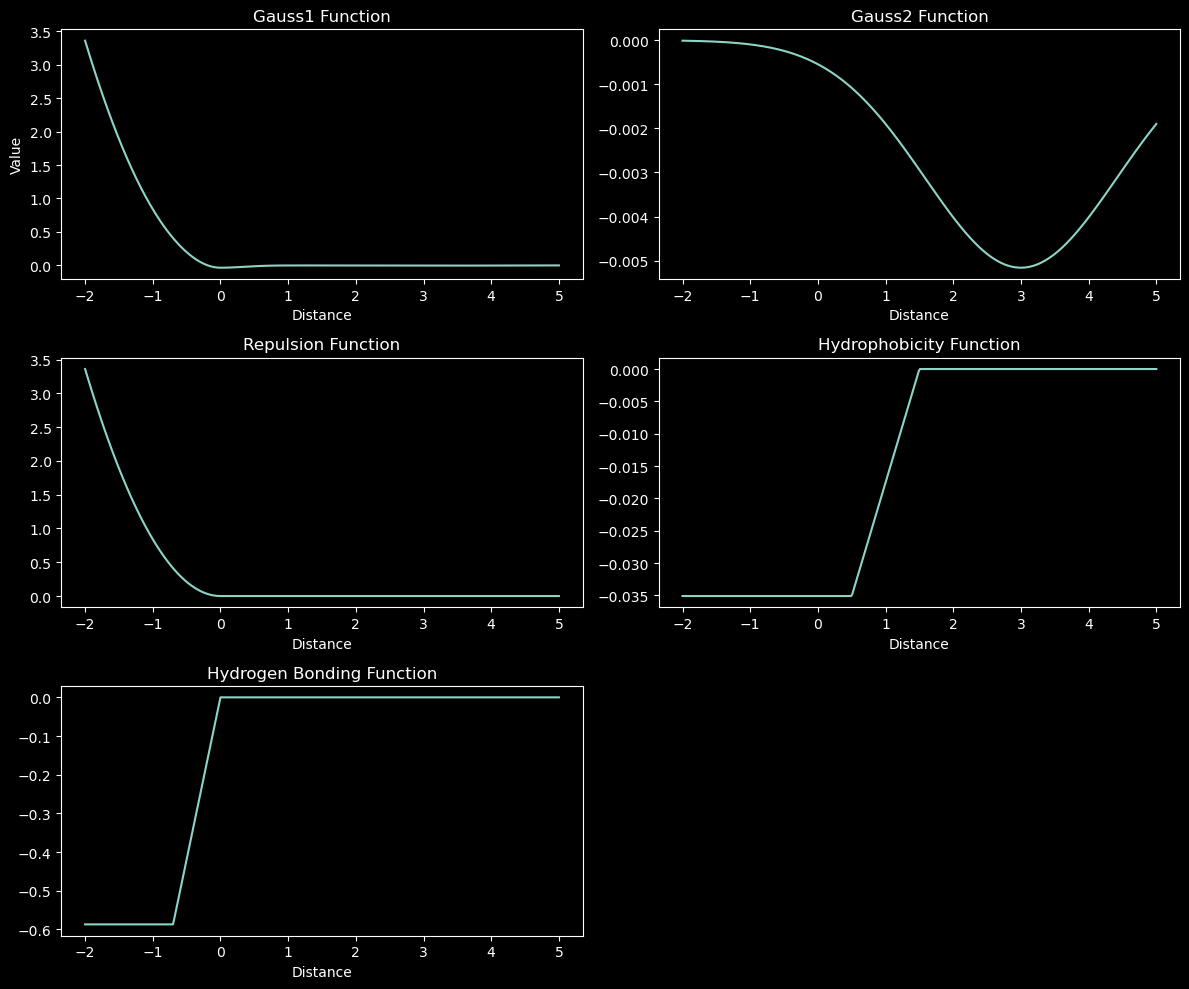

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Defining the functions based on the given equations
def gauss1(d):
    return -0.0356*np.exp(-(d/0.5)**2) + -0.00516*np.exp(-((d-3)/2)**2) + 0.840*d**2 * (d < 0)

def gauss2(d):
    return -0.00516*np.exp(-((d-3)/2)**2)

def repulsion(d):
    return 0.840*d**2 * (d < 0)

def hydrophobicity(d):
    return  -0.0351*np.where(d < 0.5, 1, np.where(d <= 1.5, 1.5 - d, 0))

def hydrogen_bonding(d):
    return -0.587*np.where(d < -0.7, 1, np.where(d <= 0, d / -0.7, 0))

# Create a range of values from -2 to 5
d = np.linspace(-2, 5, 400)

# Generate plots
plt.figure(figsize=(12, 10))

plt.subplot(321)
plt.plot(d, gauss1(d), label='gauss1')
plt.title('Gauss1 Function')
plt.xlabel('Distance')
plt.ylabel('Value')

plt.subplot(322)
plt.plot(d, gauss2(d), label='gauss2')
plt.title('Gauss2 Function')
plt.xlabel('Distance')

plt.subplot(323)
plt.plot(d, repulsion(d), label='repulsion')
plt.title('Repulsion Function')
plt.xlabel('Distance')

plt.subplot(324)
plt.plot(d, hydrophobicity(d), label='hydrophobicity')
plt.title('Hydrophobicity Function')
plt.xlabel('Distance')

plt.subplot(325)
plt.plot(d, hydrogen_bonding(d), label='hydrogen bonding')
plt.title('Hydrogen Bonding Function')
plt.xlabel('Distance')

plt.tight_layout()
plt.show()

In [3]:
from core.utils import reconstruct
from core.utils import misc, reconstruct, transforms
from rdkit import Chem
import py3Dmol
import torch


datamol = torch.load("/root/project/bfn_mol/logs/root_bfn_sbdd/add_cluster_vert/2/test_outputs_v5/20241207-005326/generated.pt")
for idx, data in enumerate(datamol):
    pred_pos, pred_v = data["pred_pos"], data["pred_v"]
    try:
        mol = data["mol"]
        mb = Chem.MolToMolBlock(mol)
        view = py3Dmol.view(width=400, height=400)
        view.addModel(mb, "sdf")  # 将 MolBlock 加入到模型中
        view.setStyle({"stick": {}})  # 设置为棍球模型（stick model）
        view.zoomTo()  # 自动调整缩放比例
        view.show()
        smiles = Chem.MolToSmiles(mol)
    except reconstruct.MolReconsError:
        if  True:
            print(f'Reconstruct failed {data["ligand_filename"]}')
        continue
    if idx>7:
        break

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [2]:
from core.utils import reconstruct
from core.utils import misc, reconstruct, transforms
from rdkit import Chem
import py3Dmol
import torch


datamol = torch.load("/root/project/bfn_mol/logs/root_bfn_sbdd/add_cluster_vert/2/test_outputs_v4/20241207-005316/generated.pt")
for idx, data in enumerate(datamol):
    pred_pos, pred_v = data["pred_pos"], data["pred_v"]
    try:
        mol = data["mol"]
        mb = Chem.MolToMolBlock(mol)
        view = py3Dmol.view(width=400, height=400)
        view.addModel(mb, "sdf")  # 将 MolBlock 加入到模型中
        view.setStyle({"stick": {}})  # 设置为棍球模型（stick model）
        view.zoomTo()  # 自动调整缩放比例
        view.show()
        smiles = Chem.MolToSmiles(mol)
    except reconstruct.MolReconsError:
        if  True:
            print(f'Reconstruct failed {data["ligand_filename"]}')
        continue
    if idx>7:
        break

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [34]:
import os
from shutil import move

# 定义数据目录
root_dir = '/root/project/bfn_mol/data/val_sample'

# 遍历 test_set_sample 文件夹下的每个子文件夹
for subdir, _, files in os.walk(root_dir):
    for file in files:
        if file.endswith('.sdf'):
            # 获取文件的完整路径
            file_path = os.path.join(subdir, file)

            # 获取父文件夹的名称，用作新的文件名的一部分
            folder_name = os.path.basename(subdir)

            # 获取原始文件名的前缀部分
            base_name = '_'.join(file.split('_')[:3])  # 取第一个部分，如 '4xli_B_rec'

            # 生成新的文件名
            new_file_name = base_name + '.sdf'

            # 生成新的文件路径
            new_file_path = os.path.join(subdir, new_file_name)

            # 如果文件名不同，则进行重命名
            if file != new_file_name:
                # 移动文件并重命名
                move(file_path, new_file_path)

                # 输出重命名信息
                print(f"文件 {file} 重命名为 {new_file_name}")

print("重命名操作完成！")

文件 5mgl_A_rec_5mgl_7mu_lig_tt_min_0.sdf 重命名为 5mgl_A_rec.sdf
文件 4ja8_B_rec_4ja8_1k9_lig_tt_docked_0.sdf 重命名为 4ja8_B_rec.sdf
文件 5w2g_A_rec_5w2i_adp_lig_tt_min_0.sdf 重命名为 5w2g_A_rec.sdf
文件 3dzh_A_rec_3u4i_cvr_lig_tt_docked_0.sdf 重命名为 3dzh_A_rec.sdf
文件 1umd_B_rec_1umb_tdp_lig_tt_docked_1.sdf 重命名为 1umd_B_rec.sdf
文件 1djy_A_rec_1djz_ip2_lig_tt_min_0.sdf 重命名为 1djy_A_rec.sdf
文件 1fmc_B_rec_1fmc_cho_lig_tt_docked_1.sdf 重命名为 1fmc_B_rec.sdf
文件 2hcj_B_rec_2hcj_gdp_lig_tt_docked_0.sdf 重命名为 2hcj_B_rec.sdf
文件 5b08_A_rec_5b09_4mx_lig_tt_min_0.sdf 重命名为 5b08_A_rec.sdf
文件 3kc1_A_rec_3kc1_2t6_lig_tt_min_0.sdf 重命名为 3kc1_A_rec.sdf
文件 4m7t_A_rec_4m7t_sam_lig_tt_min_0.sdf 重命名为 4m7t_A_rec.sdf
文件 2azy_A_rec_2azy_chd_lig_tt_docked_0.sdf 重命名为 2azy_A_rec.sdf
文件 4gvd_A_rec_4nxr_ans_lig_tt_min_0.sdf 重命名为 4gvd_A_rec.sdf
文件 4xli_B_rec_4xli_1n1_lig_tt_min_0.sdf 重命名为 4xli_B_rec.sdf
文件 2zen_A_rec_2afx_1bn_lig_tt_docked_7.sdf 重命名为 2zen_A_rec.sdf
文件 4rlu_A_rec_4rlu_hcc_lig_tt_min_0.sdf 重命名为 4rlu_A_rec.sdf
文件 3l3n_A_rec_2iux_

In [15]:
os.path.splitext(original_filename)[0]+ '_pocket10.pdb'

'BSD_ASPTE_1_130_0/2z3h_A_rec_1wn6_bst_lig_tt_docked_3_pocket10.pdb'

In [13]:
import os

# Original filename
original_filename = 'BSD_ASPTE_1_130_0/2z3h_A_rec_1wn6_bst_lig_tt_docked_3.sdf'

# Extract the part before the file extension
base_name, ext = os.path.splitext(original_filename)

# Append the suffix '_pocket10.pdb'
new_filename = base_name + '_pocket10.pdb'

print(new_filename)


BSD_ASPTE_1_130_0/2z3h_A_rec_1wn6_bst_lig_tt_docked_3_pocket10.pdb


In [12]:
import torch
path = "/root/project/bfn_mol/logs/root_bfn_sbdd/add_all/1/test_outputs_v3/20241203-102041/generated.pt"
data = torch.load(path)

In [13]:
len(data)

989

In [1]:
import os
import torch
import numpy as np
from rdkit import Chem
from collections import defaultdict

# 定义保存数据的目录
save_dir = '/root/project/bfn_mol/results/denovo/bfnmol/saved_data'
os.makedirs(save_dir, exist_ok=True)

def save_mol(mol, filename):
    """保存 RDKit 分子对象为 .sdf 文件"""
    writer = Chem.SDWriter(filename)
    writer.write(mol)
    writer.close()

# 加载生成的数据
results = torch.load("/root/project/bfn_mol/logs/root_bfn_sbdd/add_cluster_vert/2/test_outputs/20241207-072757/generated.pt")

# 按照 ligand_filename 的第一个部分进行分组
grouped_results = defaultdict(list)
for result in results:
    group_name = result['ligand_filename'].split('/')[0]  # 获取目录名
    grouped_results[group_name].append(result)

# 对每个分组进行保存
for group_name, group_results in grouped_results.items():
    group_save_dir = os.path.join(save_dir, group_name)
    os.makedirs(group_save_dir, exist_ok=True)
    
    # 遍历该组中的每个分子数据并保存
    for count, result in enumerate(group_results, 1):
        # 创建保存文件的路径
        pdb_filename = '_'.join(result['ligand_filename'].split('_')[:7])
        entry = [pdb_filename + '.pdb', result['ligand_filename']]
        data = {
            'pos': np.array(result['pred_pos']),
            'atom': np.array(result['pred_v']),
            'entry': entry
        }
        
        # 保存 .pt 数据文件
        group_result_dir = os.path.join(save_dir, result['ligand_filename'][:-4])
        os.makedirs(group_result_dir, exist_ok=True)
        
        # 保存 .pt 数据文件
        torch.save(data, os.path.join(group_result_dir, f'sample_{count:04d}.pt'))
        
        # 动态生成文件路径并保存 .sdf 文件
        save_mol(result['mol'], os.path.join(group_result_dir, f'sample_{count:04d}.sdf'))


In [12]:
grouped_results.keys()

dict_keys(['BSD_ASPTE_1_130_0', 'GLMU_STRPN_2_459_0', 'GRK4_HUMAN_1_578_0', 'GSTP1_HUMAN_2_210_0', 'GUX1_HYPJE_18_451_0', 'HDAC8_HUMAN_1_377_0', 'HDHA_ECOLI_1_255_0', 'HMD_METJA_1_358_0', 'CCPR_YEAST_69_361_0', 'IPMK_HUMAN_49_416_0', 'CD38_HUMAN_44_300_0', 'KS6A3_HUMAN_41_357_0', 'CHOD_BREST_46_552_0', 'LAT_MYCTU_1_449_0', 'LMBL1_HUMAN_198_526_0', 'M3K14_HUMAN_321_678_0', 'MENE_BACSU_2_486_0', 'NAGZ_VIBCH_1_330_0', 'NEP_HUMAN_54_750_0', 'NQO1_HUMAN_2_274_0', 'NR1H4_HUMAN_258_486_0', 'OLIAC_CANSA_1_101_0', 'PA21B_PIG_23_146_0', 'PAK4_HUMAN_291_591_ATP_0', 'PHKG1_RABIT_6_296_ATPsite_0', 'PHP_SULSO_1_314_0', 'COTA_BACSU_1_513_0', 'PLCD1_RAT_134_756_0', 'PNTM_STRAE_2_398_0', 'CPXB_BACMB_2_464_0', 'PPIA_HUMAN_1_165_0', 'PTGIS_HUMAN_20_500_0', 'QPCT_HUMAN_33_361_0', 'RIBB_VIBCH_2_218_0', 'RG1_RAUSE_1_513_0', 'ROCO4_DICDI_1009_1292_0', 'DPO4_SULSO_1_347_0', 'SDIA_ECOLI_1_171_0', 'DPP2_HUMAN_27_492_0', 'TBK1_HUMAN_1_303_0', 'TRAR_RHIRD_1_234_0', 'UBE2T_HUMAN_1_156_0', 'VAOX_PENSI_1_560_0', 'XA

In [29]:
'_'.join("BSD_ASPTE_1_130_0/2z3h_A_rec_1wn6_bst_lig_tt_docked_3.sdf".split('_')[:7])

'BSD_ASPTE_1_130_0/2z3h_A_rec'

In [3]:
import torch
results = torch.load("/root/project/bfn_mol/logs/root_bfn_sbdd/add_cluster_vert/0/test_outputs_v2/20241203-113241/generated.pt")
results

[{'mol': <rdkit.Chem.rdchem.Mol at 0x7fda8cf2a0e0>,
  'ligand_filename': 'BSD_ASPTE_1_130_0/2z3h_A_rec_1wn6_bst_lig_tt_docked_3.sdf',
  'pred_pos': array([[ 16.85332298,  37.06336975, 103.43921661],
         [ 26.67198181,  34.64614487, 105.8298111 ],
         [ 17.48666382,  35.12250137, 104.57795715],
         [ 23.75503922,  34.74684906, 106.34046936],
         [ 24.29164314,  35.17106247, 105.01785278],
         [ 30.22498894,  32.61392593, 102.48896027],
         [ 22.33377075,  35.0450592 , 106.74938202],
         [ 20.02831268,  32.54579544, 105.11312103],
         [ 17.80801582,  36.5364418 , 104.477211  ],
         [ 16.54350281,  34.66362   , 103.56316376],
         [ 31.97507477,  33.78693008, 103.51365662],
         [ 28.51601982,  34.52780151, 104.34534454],
         [ 32.06170273,  34.74557877, 104.41503906],
         [ 18.38139534,  34.23354721, 105.23394775],
         [ 24.83491898,  34.74164963, 108.36099243],
         [ 30.87287903,  35.12758255, 104.81056976],
      

In [3]:
ligand_filename = data[0]["ligand_filename"]

In [4]:
ligand_filename

'BSD_ASPTE_1_130_0/2z3h_A_rec_1wn6_bst_lig_tt_docked_3.sdf'

In [ ]:
ligand_filename

In [5]:
for idx, item in enumerate(data):
    if item.surface_pos is None:
        print(f"Item {idx} has None for surface_pos")


In [4]:
from torch_scatter import scatter_mean


def build_local_coordinate_system(atom_positions, batch_indices, offset):
    """
    针对不同 batch 的分子构建局部坐标系。
    
    Args:
        atom_positions: 原子的坐标张量，shape=(N, 3)，包含所有分子的原子。
        batch_indices: 每个原子所属的 batch，shape=(N,)。
        
    Returns:
        transform_matrices: 每个 batch 的局部坐标系变换矩阵，shape=(B, 3, 3)。
        offset: 每个 batch 的局部坐标系原点（质心），shape=(B, 3)。
    """
    # Step 1: 计算每个 batch 的质心
    batch_size = batch_indices.max() + 1
    expanded_offsets = offset[batch_indices]
    distances = torch.norm(atom_positions - expanded_offsets, dim=1) 
    sorted_indices = torch.argsort(distances)  # 按距离排序
    sorted_batch_indices = batch_indices[sorted_indices]  # 对应 batch 排序

    # 利用分组方式找到每个 batch 中的前两个最近原子
    unique_batches, inverse_indices, counts = torch.unique(sorted_batch_indices, return_inverse=True, return_counts=True)
    cumsum_counts = torch.cumsum(counts, dim=0)
    starts = torch.cat([torch.tensor([0], device=cumsum_counts.device), cumsum_counts[:-1]])  # 每个 batch 的起点索引

    # 获取前两个原子索引
    nearest_indices = torch.stack([
        sorted_indices[starts + 0],  # 最近的第一个原子
        sorted_indices[starts + 1]  # 最近的第二个原子
    ], dim=1)

    # Step 4: 构建局部坐标系
    pos_A = offset  # 质心
    pos_B = atom_positions[nearest_indices[:, 0]]  # 最近的第一个原子
    pos_C = atom_positions[nearest_indices[:, 1]]  # 最近的第二个原子

    x_axis = (pos_B - pos_A) / torch.norm(pos_B - pos_A, dim=1, keepdim=True)
    temp_vector = (pos_C - pos_A)
    z_axis = torch.cross(x_axis, temp_vector, dim=1)
    z_axis /= torch.norm(z_axis, dim=1, keepdim=True)
    y_axis = torch.cross(z_axis, x_axis, dim=1)

    transform_matrices = torch.stack([x_axis, y_axis, z_axis], dim=1)  # shape=(B, 3, 3)

    return transform_matrices

def center_pos(protein_pos, ligand_pos, batch_protein, batch_ligand, mode="protein"):
    if mode == "none":
        offset = 0.0
        pass
    elif mode == "protein":
        offset = scatter_mean(protein_pos, batch_protein, dim=0)
        protein_pos = protein_pos - offset[batch_protein]
        ligand_pos = ligand_pos - offset[batch_ligand]
    else:
        raise NotImplementedError
    return protein_pos, ligand_pos, offset

example = {
    "protein_pos": torch.rand(442, 3),  # 442 个蛋白质原子
    "ligand_pos": torch.rand(31, 3),   # 31 个配体原子
    "surface_pos": torch.rand(362, 3), # 362 个表面原子
    "batch_protein": torch.randint(0, 2, (442,)),  # 假设 10 个 batch
    "batch_ligand": torch.randint(0, 2, (31,)),
    "batch_surface": torch.randint(0, 2, (362,)),
    "offset": torch.rand(10, 3)  # 每个 batch 的质心
}

# 配置
class Config:
    class Dynamics:
        center_pos_mode = "protein"
    class Data:
        normalizer = 2.0

    dynamics = Dynamics()
    data = Data()

cfg = Config()
gt_protein_pos = example["protein_pos"]
ligand_pos = example["ligand_pos"]
surface_pos = example["surface_pos"]
batch_protein = example["batch_protein"]
batch_ligand = example["batch_ligand"]
batch_surface = example["batch_surface"]

# 执行代码
gt_protein_pos, ligand_pos, offset = center_pos(
    gt_protein_pos,
    ligand_pos,
    batch_protein,
    batch_ligand,
    mode=cfg.dynamics.center_pos_mode
)

surface_pos = surface_pos - offset[batch_surface]
transform_matrix = build_local_coordinate_system(gt_protein_pos, batch_protein, offset)
gt_protein_pos = torch.matmul(gt_protein_pos.unsqueeze(1), transform_matrix[batch_protein]).squeeze(1)
ligand_pos = torch.matmul(ligand_pos.unsqueeze(1), transform_matrix[batch_ligand]).squeeze(1)
surface_pos = torch.matmul(surface_pos.unsqueeze(1), transform_matrix[batch_surface]).squeeze(1)
gt_protein_pos = gt_protein_pos / cfg.data.normalizer

In [11]:
import plotly.graph_objects as go
import torch

def plot_3d_interactive(original_positions, rotated_positions, title="3D Positions"):
    """
    使用 Plotly 绘制原始和旋转后坐标的交互式 3D 可视化。
    
    Args:
        original_positions: 原始坐标，形状 (N, 3)。
        rotated_positions: 旋转后的坐标，形状 (N, 3)。
        title: 图的标题。
    """
    fig = go.Figure()

    # 添加原始坐标点
    fig.add_trace(go.Scatter3d(
        x=original_positions[:, 0].cpu().numpy(),
        y=original_positions[:, 1].cpu().numpy(),
        z=original_positions[:, 2].cpu().numpy(),
        mode='markers',
        marker=dict(size=5, color='blue', opacity=0.8),
        name='Original Positions'
    ))

    # 添加旋转后的坐标点
    fig.add_trace(go.Scatter3d(
        x=rotated_positions[:, 0].cpu().numpy(),
        y=rotated_positions[:, 1].cpu().numpy(),
        z=rotated_positions[:, 2].cpu().numpy(),
        mode='markers',
        marker=dict(size=5, color='red', opacity=0.8),
        name='Rotated Positions'
    ))

    # 设置布局
    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title='X-axis',
            yaxis_title='Y-axis',
            zaxis_title='Z-axis'
        ),
        margin=dict(l=0, r=0, b=0, t=40)
    )

    # 显示图形
    fig.show()


# 保存原始坐标
original_protein_pos = example["protein_pos"].clone()
original_ligand_pos = example["ligand_pos"].clone()

# 执行中心化与旋转
gt_protein_pos, ligand_pos, offset = center_pos(
    original_protein_pos,
    original_ligand_pos,
    batch_protein,
    batch_ligand,
    mode=cfg.dynamics.center_pos_mode
)
transform_matrix = build_local_coordinate_system(gt_protein_pos, batch_protein, offset)
gt_protein_pos_rotated = torch.matmul(gt_protein_pos.unsqueeze(1), transform_matrix[batch_protein]).squeeze(1)
ligand_pos_rotated = torch.matmul(ligand_pos.unsqueeze(1), transform_matrix[batch_ligand]).squeeze(1)

# 绘制交互式 3D 可视化
plot_3d_interactive(gt_protein_pos, ligand_pos, title="Protein Positions: Original vs Rotated")
plot_3d_interactive(gt_protein_pos_rotated, ligand_pos_rotated, title="Ligand Positions: Original vs Rotated")


In [5]:
import  torch 
pt = torch.load("/root/zqs_project/drug/MolCRAFT/logs/root_bfn_sbdd/add_cluster_mean/3/test_outputs_v2/20241121-102845/generated.pt")


In [7]:
pt[0]

{'mol': <rdkit.Chem.rdchem.Mol at 0x7f7325ed4a40>,
 'ligand_filename': 'BSD_ASPTE_1_130_0/2z3h_A_rec_1wn6_bst_lig_tt_docked_3.sdf',
 'pred_pos': array([[ 19.07535744,  34.89083862, 106.89019775],
        [ 24.17471313,  35.18234634, 105.21728516],
        [ 26.1620903 ,  34.51578903, 103.89488983],
        [ 23.72534561,  33.87718582, 105.25028229],
        [ 29.57939529,  33.21274948, 102.87207794],
        [ 15.53934956,  34.09431839, 102.69537354],
        [ 21.09123993,  34.18183899, 105.84368134],
        [ 20.57048607,  34.76352692, 107.14292908],
        [ 18.2828083 ,  35.71738434, 104.71507263],
        [ 19.93759155,  33.862957  , 104.9485321 ],
        [ 23.64234543,  31.64995003, 104.0189743 ],
        [ 14.83694363,  35.21371078, 102.26055145],
        [ 16.29716873,  36.64857101, 103.52635956],
        [ 22.44967079,  33.5345192 , 105.79893494],
        [ 33.13725281,  33.74886703, 105.21717072],
        [ 15.20415211,  36.48918533, 102.6739502 ],
        [ 32.00395203,  